In [40]:
import pandas as pd
#import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
#from matplotlib import style
#import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
province_cases = pd.read_csv('https://cnecovid.isciii.es/covid19/resources/casos_tecnica_provincia.csv', parse_dates=['fecha'])
province_cases = province_cases.dropna(subset=['provincia_iso'])

province_cases_uci = pd.read_csv('https://cnecovid.isciii.es/covid19/resources/casos_hosp_uci_def_sexo_edad_provres.csv', parse_dates=['fecha'])
province_cases_uci = province_cases_uci.dropna(subset=['provincia_iso'])


province_code = pd.read_csv('data/ine.es/Province_Codigo.csv', sep='\t', converters = {'CODAUTO': str, 'CPRO': str}, keep_default_na=False)

df = province_cases.merge(province_code, left_on='provincia_iso', right_on='Code', how='left')

In [3]:
#num_casos = pd.DataFrame(province_cases_uci.groupby('fecha').sum()['num_casos'])
data = pd.DataFrame(province_cases_uci.groupby('fecha').sum()['num_hosp'])

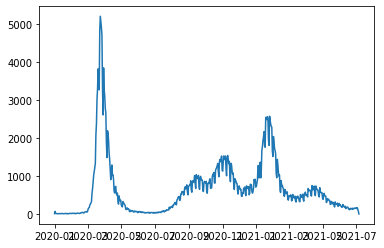

In [4]:
plt.plot(data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FECF3821C8>]],
      dtype=object)

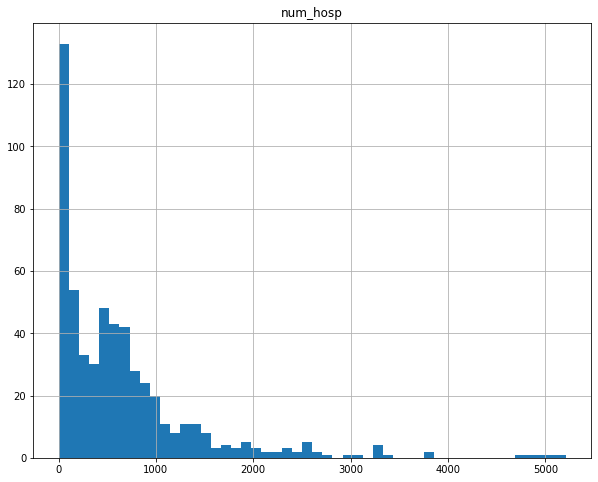

In [5]:
data.hist(bins=50, figsize=(10,8))

<Figure size 432x288 with 0 Axes>

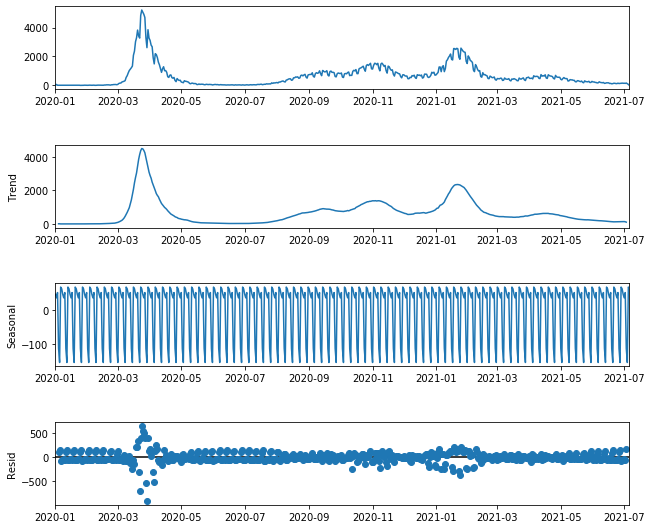

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data, period=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(10, 8)

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

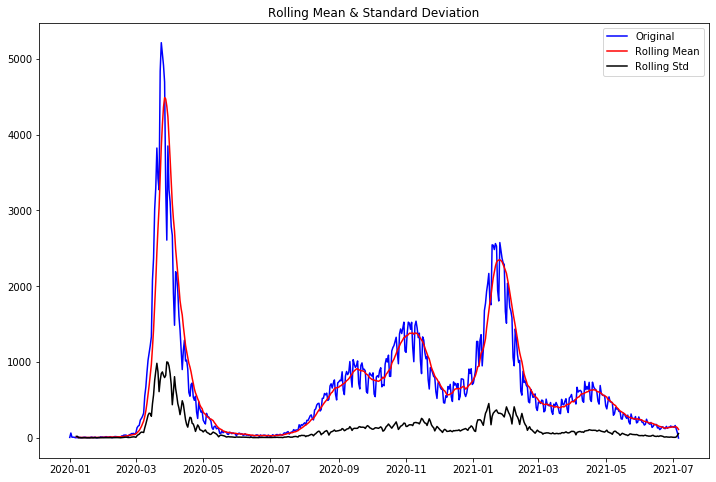

Results of Dickey-Fuller Test:
Test Statistic                  -3.533331
p-value                          0.007171
#Lags Used                      19.000000
Number of Observations Used    533.000000
Critical Value (1%)             -3.442678
Critical Value (5%)             -2.866978
Critical Value (10%)            -2.569666
dtype: float64


In [10]:
test_stationarity(data)

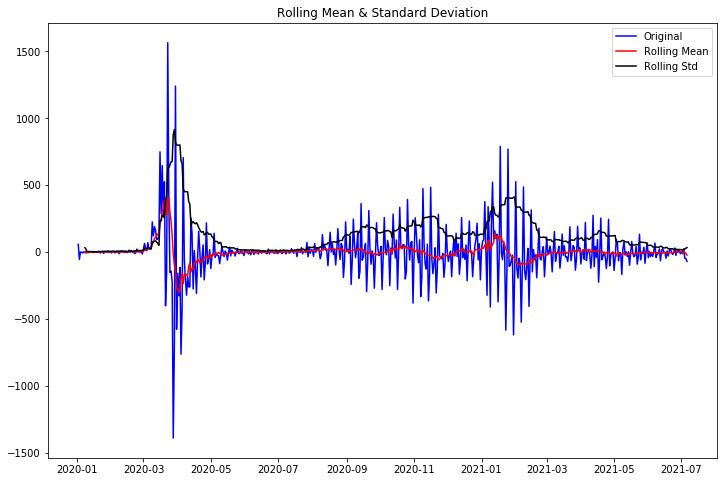

Results of Dickey-Fuller Test:
Test Statistic                  -5.332302
p-value                          0.000005
#Lags Used                      18.000000
Number of Observations Used    533.000000
Critical Value (1%)             -3.442678
Critical Value (5%)             -2.866978
Critical Value (10%)            -2.569666
dtype: float64


In [13]:
data['first_diff'] = data.num_hosp - data.num_hosp.shift(1)
test_stationarity(data.first_diff.dropna(inplace=False))

In [ ]:
#num_casos['seasonal_diff'] = num_casos.num_casos - num_casos.num_casos.shift(7)
#test_stationarity(num_casos.seasonal_diff.dropna(inplace=False))

In [ ]:
#num_casos['seasonal_first_diff'] = num_casos.first_diff - num_casos.first_diff.shift(7)
#test_stationarity(num_casos.seasonal_first_diff.dropna(inplace=False))

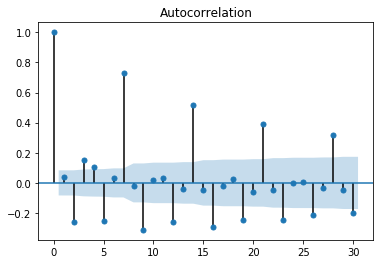

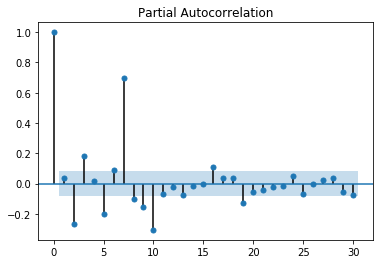

In [14]:
plot_acf(data.first_diff.iloc[1:], lags=30);
plot_pacf(data.first_diff.iloc[1:], lags=30);

In [18]:
#Build AR model
from statsmodels.tsa.arima_model import ARIMA
 
# fit model
model = ARIMA(data['num_hosp'], order=(10,1,0), freq='D')
model_fit = model.fit(update_freq=5, disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.num_hosp   No. Observations:                  552
Model:                ARIMA(10, 1, 0)   Log Likelihood               -3425.986
Method:                       css-mle   S.D. of innovations            119.369
Date:                Wed, 07 Jul 2021   AIC                           6875.972
Time:                        17:22:54   BIC                           6927.735
Sample:                    01-02-2020   HQIC                          6896.197
                         - 07-06-2021                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2795      9.308     -0.030      0.976     -18.523      17.964
ar.L1.D.num_hosp      0.0615      0.041      1.515      0.130      -0.018       0.141
ar.L2.D.num_hosp     -0.

In [ ]:
#Build seasonal model
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(df.num_casos, trend='n', order=(6,0,0), seasonal_order=(4,1,0,7), simple_differencing=True)
model_fit = model.fit()
print(results.summary())

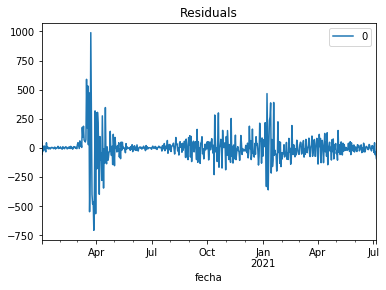

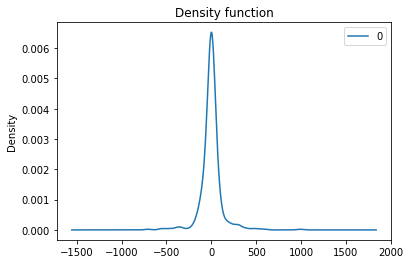

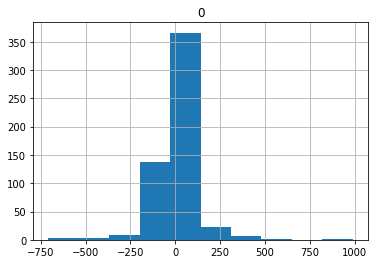

                0
count  552.000000
mean    -0.007485
std    119.515834
min   -707.158597
25%    -33.662326
50%      0.528705
75%     27.454417
max    989.294961


In [19]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title('Residuals')
plt.show()
residuals.plot(kind='kde')
plt.title('Density function')
plt.show()
# histogram plot
residuals.hist()
plt.show()
print(residuals.describe())

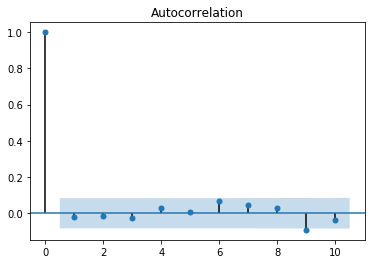

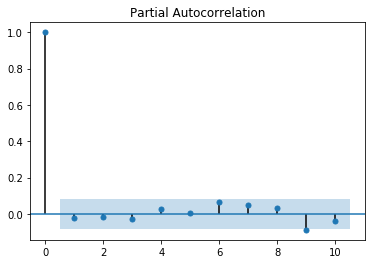

In [21]:
plot_acf(residuals, lags=10);
plot_pacf(residuals, lags=10);

No ACF or PACF, it seems WN. Check with formal BoxTest. ***H0 the time series isn't autocorrelated***

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox as boxtest

boxtest(residuals, lags=[30], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
30,31.535172,0.389452,30.53668,0.438431


In [34]:
#Train and test split
print(data.shape)
train = data.iloc[:-10]
test = data.iloc[-10:]
print(train.shape, test.shape)

(553, 2)
(543, 2) (10, 2)


In [35]:
# fit model
model = ARIMA(train['num_hosp'], order=(10,1,0), freq='D')
model_fit = model.fit(update_freq=5, disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.num_hosp   No. Observations:                  542
Model:                ARIMA(10, 1, 0)   Log Likelihood               -3368.314
Method:                       css-mle   S.D. of innovations            120.329
Date:                Wed, 07 Jul 2021   AIC                           6760.628
Time:                        17:42:52   BIC                           6812.171
Sample:                    01-02-2020   HQIC                          6780.783
                         - 06-26-2021                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3145      9.463      0.033      0.973     -18.233      18.862
ar.L1.D.num_hosp      0.0614      0.041      1.498      0.134      -0.019       0.142
ar.L2.D.num_hosp     -0.

In [36]:
#Make predictions
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ='levels')
#pred.index=data.index[start:end +1]
print(pred)

2021-06-27    150.144168
2021-06-28    178.662826
2021-06-29    175.486727
2021-06-30    161.560061
2021-07-01    161.924546
2021-07-02    183.348673
2021-07-03    165.588577
2021-07-04    179.256481
2021-07-05    199.339105
2021-07-06    195.360948
Freq: D, dtype: float64


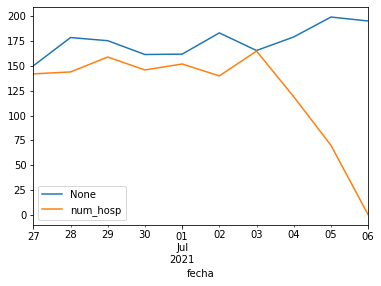

In [38]:
pred.plot(legend=True)
test['num_hosp'].plot(legend=True)

In [39]:
test['num_hosp'].mean()

123.7

In [42]:
rmse = sqrt(mean_squared_error(pred[:7], test['num_hosp'][:7]))
print(rmse)

23.175470874489957


## Rolling forecast

In [ ]:
history = [x for x in train['num_hosp']]
predictions = []


for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['num_hosp'][t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

In [50]:
predictions

[array([150.14416831]),
 array([170.00288269]),
 array([139.29741966]),
 array([144.43502806]),
 array([138.9166298]),
 array([180.04553605]),
 array([121.00790304]),
 array([176.84073761]),
 array([107.31744445]),
 array([91.03148221])]

In [64]:
predictions = pd.DataFrame(predictions, index = test.index)

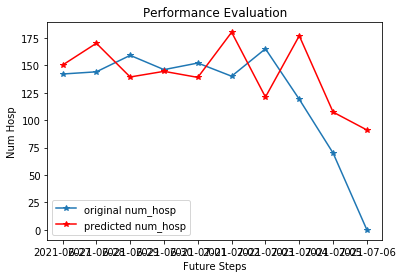

In [65]:
# plot
plt.plot(test.num_hosp, label = 'original num_hosp', marker = '*')
plt.plot(predictions, color='red', label = 'predicted num_hosp', marker = '*')
plt.title('Performance Evaluation')
plt.xlabel('Future Steps')
plt.ylabel('Num Hosp')
plt.legend()
plt.show()

In [69]:
rmse = sqrt(mean_squared_error(predictions[:7], test['num_hosp'][:7]))
print(rmse)

26.30383547076969


### A volatility model could be used, but no sense in this problem

Remember we need mean zero (0) to use the squared 

Text(0.5, 1.0, 'Residuals squared')

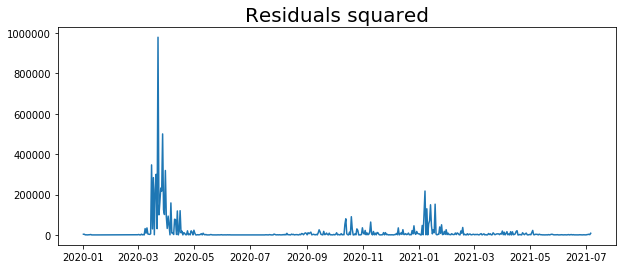

In [24]:
plt.figure(figsize=(10,4))
plt.plot(residuals**2)
plt.title('Residuals squared', fontsize=20)

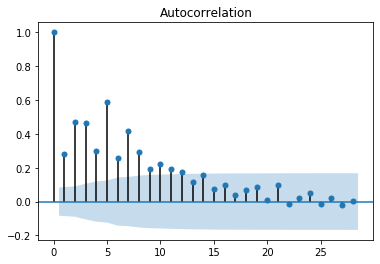

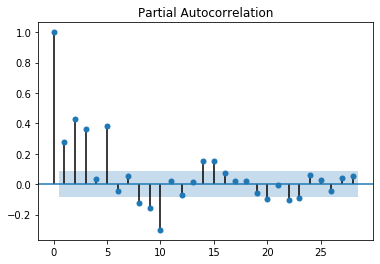

In [333]:
plot_acf(residuals**2);
plot_pacf(residuals**2);

In [351]:
from arch import arch_model

model = arch_model(residuals, p=5, o=1, q=0, dist="StudentsT")
model_fit = model.fit(update_freq=20, disp=False)
print(model_fit.summary())


C:\Users\drodriguez45\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.427e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:     20,   Func. Count:    233,   Neg. LLF: 3071.689092606604
Iteration:     40,   Func. Count:    456,   Neg. LLF: 3057.1677160109994
Iteration:     60,   Func. Count:    690,   Neg. LLF: 2994.650861776049
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            0   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2994.65
Distribution:      Standardized Student's t   AIC:                           6007.30
Method:                  Maximum Likelihood   BIC:                           6046.11
                                              No. Observations:                  551
Date:                      Wed, Jul 07 2021   Df Residuals:                      542
Time:                              00:34:24   Df Model:                            9
                  

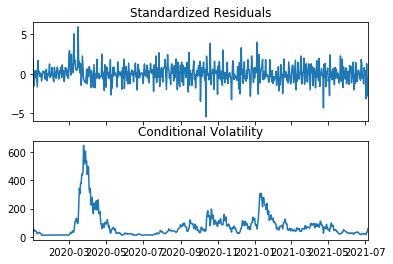

In [352]:
model_fit.plot();

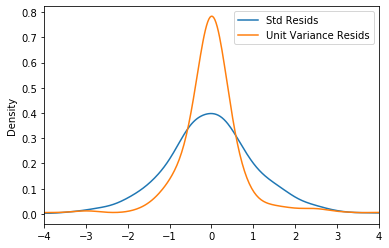

In [353]:
std_resid = model_fit.resid / model_fit.conditional_volatility
unit_var_resid = model_fit.resid / model_fit.resid.std()
df2 = pd.concat([std_resid, unit_var_resid], 1)
df2.columns = ["Std Resids", "Unit Variance Resids"]
subplot = df2.plot(kind="kde", xlim=(-4, 4))

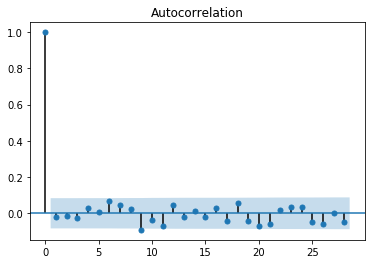

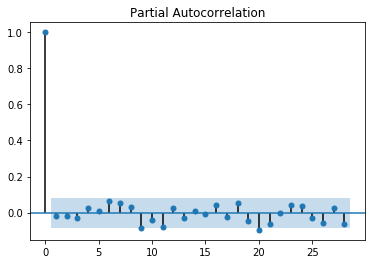

In [354]:
plot_acf(model_fit.resid);
plot_pacf(model_fit.resid);

In [355]:
pd.DataFrame(model_fit.params)

,params
mu,0.358355
omega,91.168877
alpha[1],0.133491
alpha[2],0.324479
alpha[3],0.129405
alpha[4],0.136775
alpha[5],0.206480
gamma[1],0.138740
nu,6.400030


In [357]:
sim_mod = arch_model(None, p=5, o=1, q=0, dist="StudentsT")

sim_data = sim_mod.simulate(model_fit.params, 1000)
sim_data.head()

C:\Users\drodriguez45\Anaconda3\lib\site-packages\arch\univariate\volatility.py:1061: InitialValueWarning: Parameters are not consistent with a stationary model. Using the intercept
to initialize the model.

  warn(initial_value_warning, InitialValueWarning)


,data,volatility,errors
0,-14.273545,18.913824,-14.631900
1,-22.018709,16.591687,-22.377064
2,-5.819560,18.473419,-6.177915
3,-20.365510,18.388514,-20.723865
4,-22.160587,19.598688,-22.518943


C:\Users\drodriguez45\Anaconda3\lib\site-packages\arch\univariate\base.py:293: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.427e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:     20,   Func. Count:    233,   Neg. LLF: 3071.689092606604
Iteration:     40,   Func. Count:    456,   Neg. LLF: 3057.1677160109994
Iteration:     60,   Func. Count:    690,   Neg. LLF: 2994.650861776049


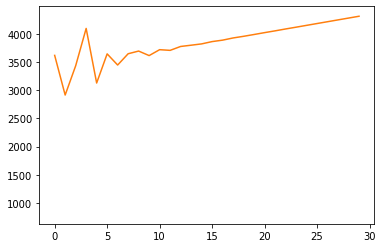

In [359]:
# split into train/test
n_test = 30
train, test = residuals[:-n_test], residuals[-n_test:]

model = arch_model(residuals,  p=5, o=1, q=0, dist="StudentsT")
model_fit = model.fit(update_freq=20, disp=False)

# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
# plot the actual variance
plt.plot(test.var())
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()